# Fallacy Identification Analysis
<!--TABLE OF CONTENTS-->
**Contents**

- [Experiment 1.1: Fallacy Identification with Zero-Shot Prompt](#Experiment-1.1:-Fallacy-Identification-with-Zero-Shot-Prompt)
  - [Scoring and Sanity Check](#Scoring-and-Sanity-Check)
  - [Overall Accuracies](#Overall-Accuracies)
  - [Fallacy Category Accuracies](#Fallacy-Category-Accuracies)
  - [Fallacy Subcategory Accuracies](#Fallacy-Subcategory-Accuracies)
  - [Accuracy Table](#Accuracy-Table)
  - [Overall Confusion Metrics](#Overall-Confusion-Metrics)
  - [LLM Confusion Metrics](#LLM-Confusion-Metrics)
  - [Large vs. Small Model Confusion Metrics](#Large-vs.-Small-Model-Confusion-Metrics)
  - [Best vs. Worst Model Confusion Metrics](#Best-vs.-Worst-Model-Confusion-Metrics)
  - [Category Confusion Metrics](#Category-Confusion-Metrics)
  - [Subcategory Confusion Metrics](#Subcategory-Confusion-Metrics)
  - [Fallacy Confusion Metrics](#Fallacy-Confusion-Metrics)
  - [Human Confusion Matrix: Adrian](#Human-Confusion-Matrix:-Adrian)
- [Experiment 1.2: Fallacy Identification with Few-Shot Prompt](#Experiment-1.2:-Fallacy-Identification-with-Few-Shot-Prompt)
  - [Scoring and Sanity Check](#Scoring-and-Sanity-Check)
  - [Overall Accuracies](#Overall-Accuracies)
  - [Fallacy Category Accuracies](#Fallacy-Category-Accuracies)
  - [Fallacy Subcategory Accuracies](#Fallacy-Subcategory-Accuracies)
- [Experiment 1.3: Fallacy Identification with Chain-of-Thought Prompt](#Experiment-1.3:-Fallacy-Identification-with-Chain-of-Thought-Prompt)
  - [Scoring and Sanity Check](#Scoring-and-Sanity-Check)
  - [Overall Accuracies](#Overall-Accuracies)
  - [Fallacy Category Accuracies](#Fallacy-Category-Accuracies)
  - [Fallacy Subcategory Accuracies](#Fallacy-Subcategory-Accuracies)
  - [Llama 3.1 8B Confusion Matrix](#Llama-3.1-8B-Confusion-Matrix)
- [Prompt Method Comparison](#Prompt-Method-Comparison)
- [Experiment 1.4: Fallacy Identification with Fine-Tuning](#Experiment-1.4:-Fallacy-Identification-with-Fine-Tuning)
  - [Scoring and Sanity Check](#Scoring-and-Sanity-Check)
  - [Overall Accuracies](#Overall-Accuracies)
  - [Fallacy Category Accuracies](#Fallacy-Category-Accuracies)
  - [Fallacy Confusion Metrics](#Fallacy-Confusion-Metrics)
- [Experiment 1.5: Fallacy Identification with Rephrased Prompt](#Experiment-1.5:-Fallacy-Identification-with-Rephrased-Prompt)
  - [Scoring and Sanity Check](#Scoring-and-Sanity-Check)
  - [Overall Accuracies](#Overall-Accuracies)
  - [Accuracy Table](#Accuracy-Table)
  - [Overall Confusion Metrics](#Overall-Confusion-Metrics)
  - [LLM Confusion Metrics](#LLM-Confusion-Metrics)
  - [Claude Sonnet Confusion Metrics](#Claude-Sonnet-Confusion-Metrics)
- [Experiment 1.6: Fallacy Identification Reliability Test](#Experiment-1.6:-Fallacy-Identification-Reliability-Test)
  - [Scoring and Sanity Check](#Scoring-and-Sanity-Check)
  - [Overall Accuracies](#Overall-Accuracies)
  - [Accuracy Table](#Accuracy-Table)
  - [Differences between Experiments 1.1 and 1.6](#Differences-between-Experiments-1.1-and-1.6)

In [113]:
%load_ext autoreload
%autoreload 2

from src.fallacies import get_fallacy_df, save_fallacy_df
from src.constants import RESPONSE_ERROR
from src.analysis import (
    get_sanity_check,
    add_identification_scores,
    get_macro_accuracies,
    add_llm_info,
    get_confusion_matrices,
    get_confusion_metrics,
    get_identification_confusion_metrics,
)
from src.plot import plot_accuracies, plot_identification_confusion_matrix
from src.table import display_llm_table, get_hong_table, get_llm_confusion_metrics_table
from src.llms import LLM, LLMGroup
from src.fallacies import add_taxonomy
import seaborn as sns
import pandas as pd

sns.set_theme()

# Set to True to add human data to the analysis
ADD_HUMAN_DATA = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Experiment 1.1: Fallacy Identification with Zero-Shot Prompt

In [114]:
filename_e11 = 'data/fallacies_e11.csv'
df_fallacies_e11 = get_fallacy_df(filename_e11)

# The new claude 3.5 sonnet (20241022) performs very similary to the older version and is excluded
drop_cols = [col for col in df_fallacies_e11.columns if col.startswith('claude_3_5_sonnet_20241022')]
df_fallacies_e11.drop(columns=drop_cols, inplace=True)

[2025-01-30 23:20:43] Loaded existing fallacy dataframe from data/fallacies_e11.csv.


In [115]:
if ADD_HUMAN_DATA:
    df_human_fallacies_e11 = pd.read_csv('data/fallacies_e11_human.csv')
    df_human_fallacies_e11 = df_human_fallacies_e11.set_index('index').fillna('')
    
    # Consider only human responses for the q180 set
    # df_human_fallacies_e11 = df_human_fallacies_e11[df_human_fallacies_e11['q180'] == 1]
    
    # Add human responses to the e11 dataframe
    join_cols = [col for col in df_human_fallacies_e11.columns if col.endswith('_response')] + ['q180']
    df_fallacies_e11 = df_fallacies_e11.join(df_human_fallacies_e11[join_cols])
    df_fallacies_e11[join_cols] = df_fallacies_e11[join_cols].fillna('')
    
    # Limit all responses to the q180 set
    # df_fallacies_e11 = df_fallacies_e11[df_fallacies_e11['q180'] == 1]


### Scoring and Sanity Check

In [116]:
# If incomplete human data is added, don't punish missing responses
add_identification_scores(df_fallacies_e11, punish_missing=not ADD_HUMAN_DATA)

# save_fallacy_df(df_fallacies_e11, filename_e11)

df_fallacies_e11.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,gpt_4_response,gpt_4o_mini_response,claude_3_5_sonnet_response,...,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score,o1_mini_pred,o1_mini_score,deepseek_r1_14b_response,deepseek_r1_14b_pred,deepseek_r1_14b_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,"<think> Okay, so I'm trying to figure out whet...",1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,"<think> Okay, so I'm trying to figure out whet...",1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,"<think> Okay, so I'm trying to figure out if t...",1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,"<think> Okay, so I'm trying to figure out if t...",1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No,No.,No,...,1,1,1,1,1,1,1,"<think> Okay, so I'm trying to figure out if t...",1,1


In [117]:
if ADD_HUMAN_DATA:
    # Add scoring to df_human_fallacies_e11 as well, so it can be looked at easily
    join_cols = ['fallacy', 'label', 'gpt_4_score', 'gpt_4o_score', 'claude_3_5_sonnet_score']
    df_human_fallacies_e11 = df_human_fallacies_e11.join(df_fallacies_e11[join_cols])
    add_identification_scores(df_human_fallacies_e11, punish_missing=False)
    
    # Save human errors
    df_human_fallacies_e11[df_human_fallacies_e11['adrian_score'] == 0].sort_index().to_csv('data/fallacies_e11_human_errors.csv')

In [118]:
# Check completeness of responses, predictions and scores
df_fallacies_e11.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   gpt_4_response                4640 non-null   object  
 8   gpt_4o_mini_response          4640 non-null   object  
 9   claude_3_5_sonnet_response    4640 non-null   object  
 10  claude_3_opus_response        4640 non-null   object  
 11  claude_3_haiku_response       4640 non-null   object  
 12  gemini_1_5_pro_response       4640 non-null   ob

In [119]:
display_llm_table(get_sanity_check(df_fallacies_e11))

,response_length_mean,missing_responses,invalid_predictions
llm_label,,,
GPT-4o,3.3,0,0
GPT-4,2.5,0,0
GPT-4o Mini,3.4,0,0
Claude 3.5 Sonnet,2.4,0,0
Claude 3 Opus,3.2,0,0
Claude 3 Haiku,3.3,0,0
Gemini 1.5 Pro,2.5,0,0
Gemini 1.5 Flash,2.4,0,0
Gemini 1.5 Flash 8B,2.4,0,0


### Overall Accuracies

In [120]:
_, df_subcategory_accuracies_e11, df_category_accuracies_e11, df_overall_accuracies_e11 = get_macro_accuracies(df_fallacies_e11)

In [121]:
df_overall_accuracies_e11 = df_overall_accuracies_e11.sort_values('accuracy', ascending=False)
display_llm_table(df_overall_accuracies_e11)

,accuracy
llm_label,
GPT-4,88.139
Gemini 1.5 Pro,87.137
GPT-4o,86.775
o1-mini,85.851
Claude 3 Opus,83.946
Claude 3.5 Sonnet,83.764
GPT-4o Mini,83.049
Llama 3.1 70B,82.953
Gemini 1.5 Flash,82.153


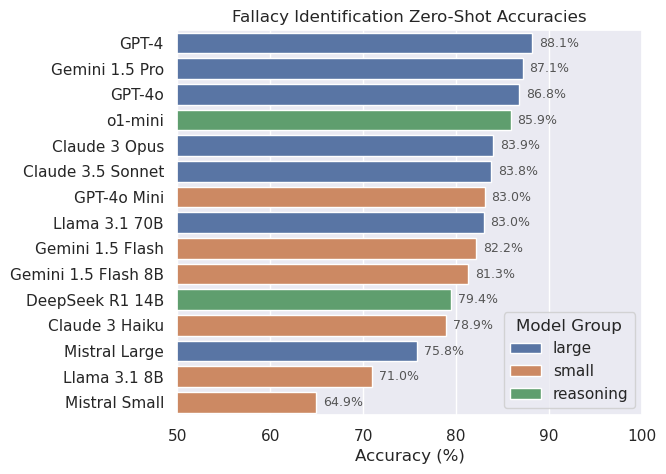

In [122]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e11),
    figsize=(6, 5),
    title='Fallacy Identification Zero-Shot Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

- GPT-4 still performs best, despite being a relatively outdated model. The overall accuracy of 88.1% is very close to the 87.7% obtained by Hong et al. (2024).
- The flagship models GPT-4, Gemini 1.5 Pro, and Claude 3.5 Sonnet perform similarly.
- The small models fall off in accuracy, but still achieve better results than the weaker models in the study by Hong et al. (2024).

### Fallacy Category Accuracies

In [123]:
display_llm_table(df_category_accuracies_e11, digits=1)

category,formal,informal
llm_label,,
GPT-4o,85.4,88.1
GPT-4,88.1,88.2
GPT-4o Mini,79.0,87.1
Claude 3.5 Sonnet,85.0,82.5
Claude 3 Opus,84.8,83.1
Claude 3 Haiku,75.7,82.2
Gemini 1.5 Pro,87.6,86.7
Gemini 1.5 Flash,81.6,82.7
Gemini 1.5 Flash 8B,78.9,83.7


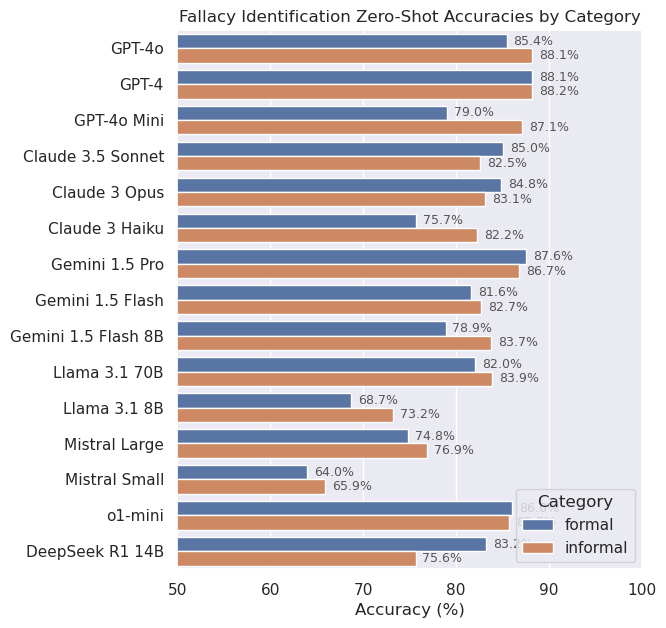

In [124]:
df_category_accuracies_long_e11 = pd.melt(df_category_accuracies_e11, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e11),
    figsize=(6, 7),
    title='Fallacy Identification Zero-Shot Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

- Lightweight models like GPT-4o Mini, Claude 3 Haiku, and Gemini 1.5 Flash 8B perform worse on formal compared to informal fallacy identification. This replicates the findings by Hong et al. (2024).
- The flagship models perform similarly on formal and informal fallacy identification.

In [125]:
df_plot = add_llm_info(df_category_accuracies_long_e11, group=True).groupby(['llm_group', 'category'], observed=True).mean().reset_index()
df_plot

,llm_group,category,accuracy
0,large,formal,83.958333
1,large,informal,84.1972
2,small,formal,74.635417
3,small,informal,79.141442
4,reasoning,formal,84.609375
5,reasoning,informal,80.669265


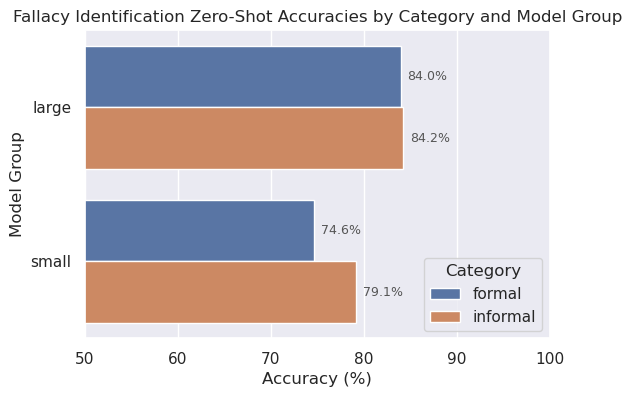

In [126]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Fallacy Identification Zero-Shot Accuracies by Category and Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='category',
    legend_title='Category',
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    annotate=True,
    xlim=(50, 100),
)

- When grouping the LLMs into large and small models, the underperformance of small models on formal fallacies becomes more apparent.

### Fallacy Subcategory Accuracies

In [127]:
display_llm_table(df_subcategory_accuracies_e11.droplevel(0, axis=1), digits=1)

subcategory,probabilistic,propositional,quantificational,syllogistic,ambiguity,inappropriate presumption,inconsistency,insufficiency,irrelevance
llm_label,,,,,,,,,
GPT-4o,87.5,83.3,80.8,90.0,85.0,87.0,88.3,92.4,87.9
GPT-4,86.2,93.3,84.2,88.8,84.7,86.9,85.0,94.0,90.2
GPT-4o Mini,77.5,80.0,74.2,84.4,84.3,87.0,86.7,91.1,86.3
Claude 3.5 Sonnet,81.2,86.7,80.8,91.2,78.7,84.3,81.7,86.9,81.2
Claude 3 Opus,83.8,85.0,86.7,83.8,82.0,84.0,83.3,86.6,79.6
Claude 3 Haiku,78.8,69.2,74.2,80.6,81.0,83.1,78.3,85.9,82.7
Gemini 1.5 Pro,88.8,85.0,85.8,90.6,85.7,88.1,80.0,92.1,87.8
Gemini 1.5 Flash,76.2,81.7,81.7,86.9,80.0,84.4,81.7,86.6,80.7
Gemini 1.5 Flash 8B,76.2,77.5,76.7,85.0,81.7,84.6,81.7,88.1,82.5


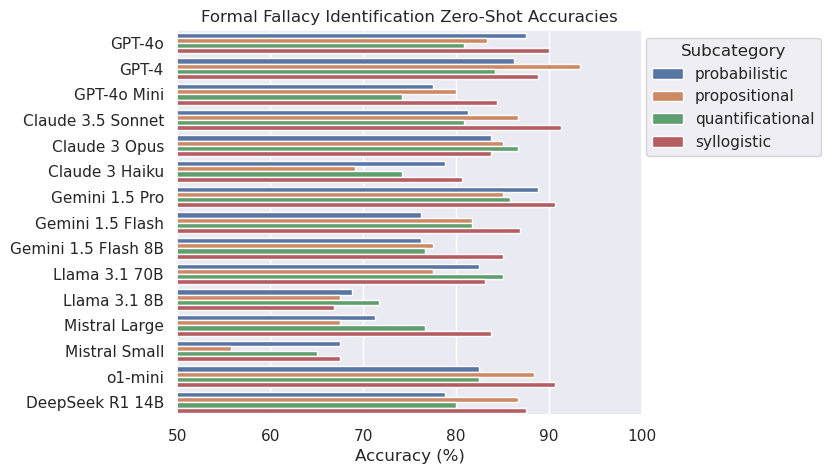

In [128]:
df_subcategory_accuracies_long_e11 = pd.melt(df_subcategory_accuracies_e11, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e11 = df_subcategory_accuracies_long_e11[
    df_subcategory_accuracies_long_e11['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e11),
    figsize=(6, 5),
    title='Formal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

In [129]:
df_plot = add_llm_info(df_formal_accuracies_long_e11, group=True).groupby(['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,formal,probabilistic,83.035714
1,large,formal,propositional,82.619048
2,large,formal,quantificational,82.857143
3,large,formal,syllogistic,87.321429
4,small,formal,probabilistic,74.166667
5,small,formal,propositional,71.944444
6,small,formal,quantificational,73.888889
7,small,formal,syllogistic,78.541667
8,reasoning,formal,probabilistic,80.625
9,reasoning,formal,propositional,87.5


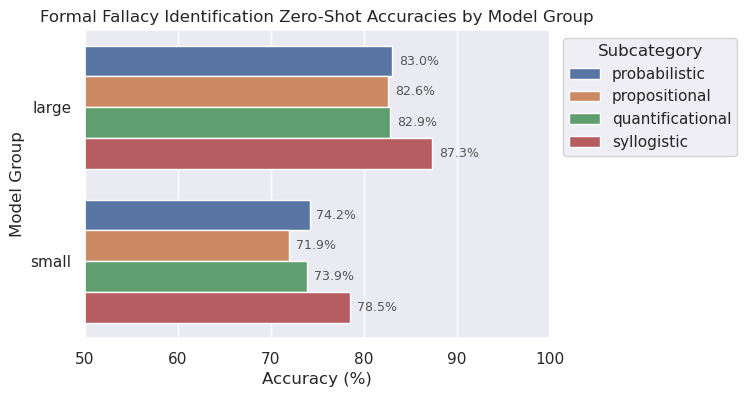

In [130]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Formal Fallacy Identification Zero-Shot Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    # order=[group.value for group in [LLMGroup.FLAGSHIP, LLMGroup.MEDIUM, LLMGroup.LIGHTWEIGHT]],
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.42, 1),
    annotate=True,
    xlim=(50, 100),
)

- Large models outperform small ones
- Both perform best on syllogistic formal fallacies


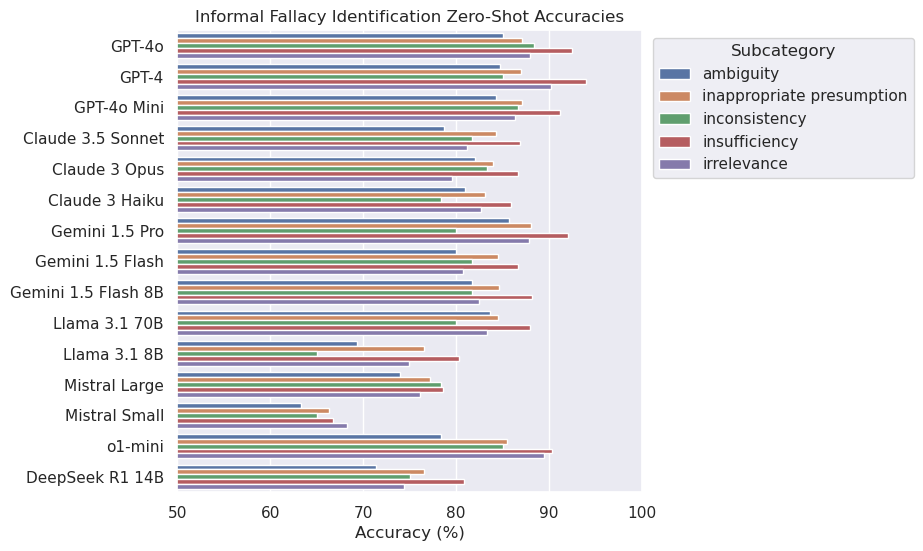

In [131]:
df_informal_accuracies_long_e11 = df_subcategory_accuracies_long_e11[
    df_subcategory_accuracies_long_e11['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e11),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

In [132]:
df_plot = add_llm_info(df_informal_accuracies_long_e11, group=True).groupby(['llm_group', 'category', 'subcategory'], observed=True).mean().reset_index()
df_plot

,llm_group,category,subcategory,accuracy
0,large,informal,ambiguity,81.952381
1,large,informal,inappropriate presumption,84.563492
2,large,informal,inconsistency,82.380952
3,large,informal,insufficiency,88.362069
4,large,informal,irrelevance,83.727106
5,small,informal,ambiguity,76.611111
6,small,informal,inappropriate presumption,80.354938
7,small,informal,inconsistency,76.388889
8,small,informal,insufficiency,83.132184
9,small,informal,irrelevance,79.220085


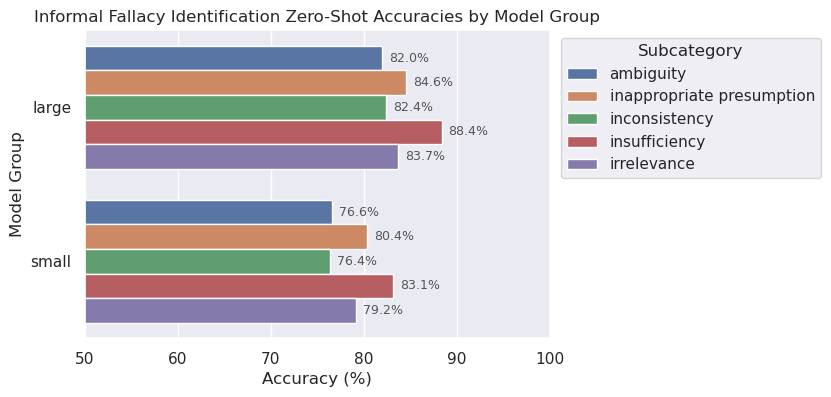

In [133]:
plot_accuracies(
    data=df_plot,
    figsize=(6, 4),
    title='Informal Fallacy Identification Zero-Shot Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='subcategory',
    # order=[group.value for group in [LLMGroup.FLAGSHIP, LLMGroup.MEDIUM, LLMGroup.LIGHTWEIGHT]],
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=True,
    xlim=(50, 100),
)

- Small models perform a bit worse, but show the same pattern as large models
- Best performance for insufficiency fallacies (the premises are insufficient or weak to support the conclusion)


### Accuracy Table

Reproduce accuracy table by Hong et al. (2024)

In [134]:
# Create LaTeX table
df_accuracies_e11 = get_hong_table(df_subcategory_accuracies_e11, df_category_accuracies_e11, df_overall_accuracies_e11)
df_accuracies_e11

,prop.,quant.,syl.,prob.,formal,amb.,incon.,irrel.,insuf.,inappr.,informal,accuracy
Model,,,,,,,,,,,,
GPT-4,93.3,84.2,88.8,86.2,88.1,84.7,85.0,90.2,94.0,86.9,88.2,88.1
Gemini 1.5 Pro,85.0,85.8,90.6,88.8,87.6,85.7,80.0,87.8,92.1,88.1,86.7,87.1
GPT-4o,83.3,80.8,90.0,87.5,85.4,85.0,88.3,87.9,92.4,87.0,88.1,86.8
o1-mini,88.3,82.5,90.6,82.5,86.0,78.3,85.0,89.4,90.3,85.5,85.7,85.9
Claude 3 Opus,85.0,86.7,83.8,83.8,84.8,82.0,83.3,79.6,86.6,84.0,83.1,83.9
Claude 3.5 Sonnet,86.7,80.8,91.2,81.2,85.0,78.7,81.7,81.2,86.9,84.3,82.5,83.8
GPT-4o Mini,80.0,74.2,84.4,77.5,79.0,84.3,86.7,86.3,91.1,87.0,87.1,83.0
Llama 3.1 70B,77.5,85.0,83.1,82.5,82.0,83.7,80.0,83.3,87.9,84.4,83.9,83.0
Gemini 1.5 Flash,81.7,81.7,86.9,76.2,81.6,80.0,81.7,80.7,86.6,84.4,82.7,82.2


In [135]:
print(df_accuracies_e11.to_latex(float_format="%.1f", column_format='l'+'c'*12,
                                 caption='Fallacy Identification Accuracies'))

\begin{table}
\caption{Fallacy Identification Accuracies}
\begin{tabular}{lcccccccccccc}
\toprule
 & prop. & quant. & syl. & prob. & formal & amb. & incon. & irrel. & insuf. & inappr. & informal & accuracy \\
Model &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
GPT-4 & 93.3 & 84.2 & 88.8 & 86.2 & 88.1 & 84.7 & 85.0 & 90.2 & 94.0 & 86.9 & 88.2 & 88.1 \\
Gemini 1.5 Pro & 85.0 & 85.8 & 90.6 & 88.8 & 87.6 & 85.7 & 80.0 & 87.8 & 92.1 & 88.1 & 86.7 & 87.1 \\
GPT-4o & 83.3 & 80.8 & 90.0 & 87.5 & 85.4 & 85.0 & 88.3 & 87.9 & 92.4 & 87.0 & 88.1 & 86.8 \\
o1-mini & 88.3 & 82.5 & 90.6 & 82.5 & 86.0 & 78.3 & 85.0 & 89.4 & 90.3 & 85.5 & 85.7 & 85.9 \\
Claude 3 Opus & 85.0 & 86.7 & 83.8 & 83.8 & 84.8 & 82.0 & 83.3 & 79.6 & 86.6 & 84.0 & 83.1 & 83.9 \\
Claude 3.5 Sonnet & 86.7 & 80.8 & 91.2 & 81.2 & 85.0 & 78.7 & 81.7 & 81.2 & 86.9 & 84.3 & 82.5 & 83.8 \\
GPT-4o Mini & 80.0 & 74.2 & 84.4 & 77.5 & 79.0 & 84.3 & 86.7 & 86.3 & 91.1 & 87.0 & 87.1 & 83.0 \\
Llama 3.1 70B & 77.5 & 85.0 & 83.1 & 82.5 & 82.0

### Overall Confusion Metrics



In [136]:
df_confusion_matrices_e11 = get_confusion_matrices(df_fallacies_e11, 'label')

In [137]:
df_overall_confusion_matrix_e11 = df_confusion_matrices_e11.groupby(['label'], observed=True).sum()
df_overall_confusion_matrix_e11

actual,1,0
label,,
1,32303,9607
0,2487,25185


In [138]:
# We only care about the metrics for label 1 (fallacy)
df_overall_confusion_metrics_e11 = get_confusion_metrics(df_overall_confusion_matrix_e11)
df_overall_confusion_metrics_e11

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar
1,32303,25185,9607,2487,3.9,0.826191,0.770771,0.928514,0.842321,0.0
0,25185,32303,2487,9607,0.3,0.826191,0.910126,0.723873,0.806384,0.0


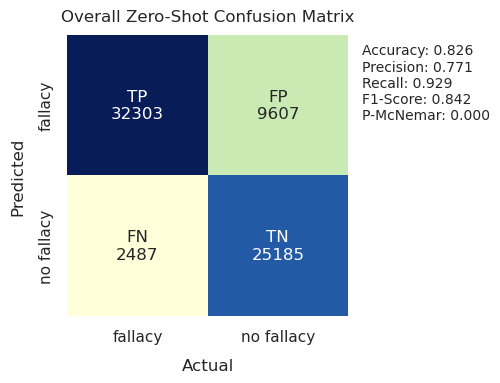

In [139]:
plot_identification_confusion_matrix(
    df_overall_confusion_metrics_e11.loc[1],
    title='Overall Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- LLMs tend to generate false alarms (judge valid reasoning as invalid)
- The overall accuracy of 83.0% is very high.

### LLM Confusion Metrics

In [140]:
df_llm_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'llm')
df_latex = get_llm_confusion_metrics_table(df_llm_confusion_metrics_e11)
df_latex

,TP,TN,FP,FN,FP/FN,Accuracy,Precision,Recall,F1,P-McNemar
Model,,,,,,,,,,
GPT-4,2017,2148,172,303,0.6,0.898,0.921,0.869,0.895,0.000
Gemini 1.5 Pro,2090,2025,295,230,1.3,0.887,0.876,0.901,0.888,0.005
GPT-4o,2031,2071,249,289,0.9,0.884,0.891,0.875,0.883,0.093
o1-mini,2013,2055,260,299,0.9,0.879,0.886,0.871,0.878,0.108
GPT-4o Mini,2086,1944,376,234,1.6,0.869,0.847,0.899,0.872,0.000
Llama 3.1 70B,2202,1723,596,118,5.1,0.846,0.787,0.949,0.860,0.000
Gemini 1.5 Flash 8B,2133,1766,554,187,3.0,0.840,0.794,0.919,0.852,0.000
Claude 3.5 Sonnet,2209,1672,648,111,5.8,0.836,0.773,0.952,0.853,0.000
Gemini 1.5 Flash,2159,1702,618,161,3.8,0.832,0.777,0.931,0.847,0.000


In [141]:
df_latex.drop(columns=['P-McNemar'], inplace=True)
print(df_latex.to_latex(float_format="%.3f", column_format='l' + 'c'*9,
                        caption='Fallacy Identification Confusion Metrics'))

\begin{table}
\caption{Fallacy Identification Confusion Metrics}
\begin{tabular}{lccccccccc}
\toprule
 & TP & TN & FP & FN & FP/FN & Accuracy & Precision & Recall & F1 \\
Model &  &  &  &  &  &  &  &  &  \\
\midrule
GPT-4 & 2017 & 2148 & 172 & 303 & 0.600 & 0.898 & 0.921 & 0.869 & 0.895 \\
Gemini 1.5 Pro & 2090 & 2025 & 295 & 230 & 1.300 & 0.887 & 0.876 & 0.901 & 0.888 \\
GPT-4o & 2031 & 2071 & 249 & 289 & 0.900 & 0.884 & 0.891 & 0.875 & 0.883 \\
o1-mini & 2013 & 2055 & 260 & 299 & 0.900 & 0.879 & 0.886 & 0.871 & 0.878 \\
GPT-4o Mini & 2086 & 1944 & 376 & 234 & 1.600 & 0.869 & 0.847 & 0.899 & 0.872 \\
Llama 3.1 70B & 2202 & 1723 & 596 & 118 & 5.100 & 0.846 & 0.787 & 0.949 & 0.860 \\
Gemini 1.5 Flash 8B & 2133 & 1766 & 554 & 187 & 3.000 & 0.840 & 0.794 & 0.919 & 0.852 \\
Claude 3.5 Sonnet & 2209 & 1672 & 648 & 111 & 5.800 & 0.836 & 0.773 & 0.952 & 0.853 \\
Gemini 1.5 Flash & 2159 & 1702 & 618 & 161 & 3.800 & 0.832 & 0.777 & 0.931 & 0.847 \\
Claude 3 Opus & 2191 & 1665 & 655 & 129 & 5.10

- Note that the accuracies differ from the macro-averaged accuracies, as the confusion matrix is calculated on the level of individual reasoning steps.

### Large vs. Small Model Confusion Metrics



In [142]:
df_group_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'llm_group')
df_group_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar
large,14984,12627,3612,1256,2.9,0.850,0.806,0.923,0.860,0.0
small,13142,9080,4840,778,6.2,0.798,0.731,0.944,0.824,0.0
reasoning,4177,3478,1155,453,2.5,0.826,0.783,0.902,0.839,0.0


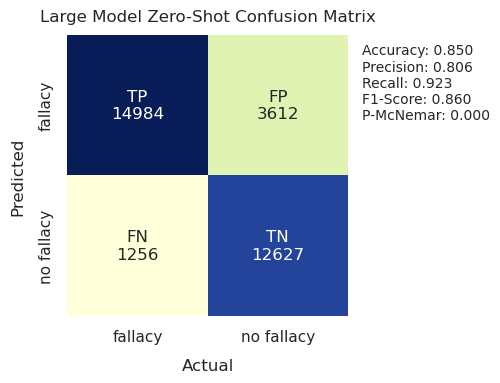

In [143]:
plot_identification_confusion_matrix(
    df_group_confusion_metrics_e11.loc[LLMGroup.LARGE.value],
    title='Large Model Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

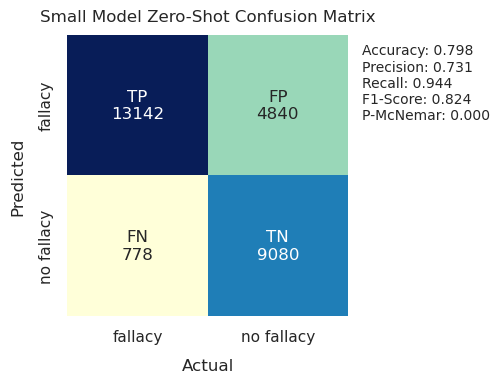

In [144]:
plot_identification_confusion_matrix(
    df_group_confusion_metrics_e11.loc[LLMGroup.SMALL.value],
    title='Small Model Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- Small models have a stronger tendency to generate false positives than large models (judge valid reasoning as invalid)



### Best vs. Worst Model Confusion Metrics

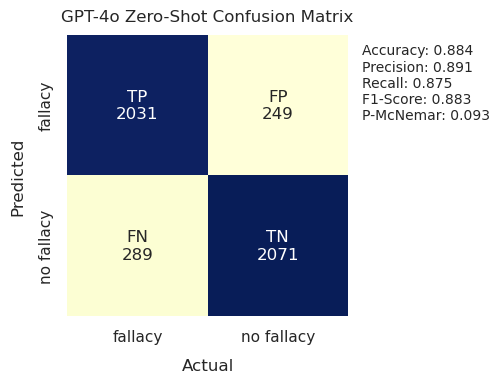

In [145]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e11.loc[LLM.GPT_4O.key],
    title=f'{LLM.GPT_4O.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- The best models have no bias towards false positives or false negatives.

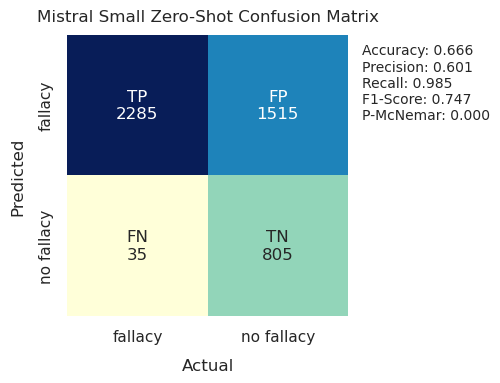

In [146]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e11.loc[LLM.MISTRAL_SMALL_2.key],
    title=f'{LLM.MISTRAL_SMALL_2.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

- The worst models have a strong bias towards false positives.

### Category Confusion Metrics

In [147]:
df_category_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'category')
df_category_confusion_metrics_e11 = df_category_confusion_metrics_e11
df_category_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar
formal,3207,2605,993,392,2.5,0.808,0.764,0.891,0.822,0.0
informal,29096,22580,8614,2095,4.1,0.828,0.772,0.933,0.845,0.0


- False positives are more common than false negatives for both categories.

### Subcategory Confusion Metrics

In [148]:
df_subcategory_confusion_metrics_e11 = get_identification_confusion_metrics(df_confusion_matrices_e11, 'subcategory')
df_subcategory_confusion_metrics_e11 = df_subcategory_confusion_metrics_e11
df_subcategory_confusion_metrics_e11.round(3)

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar
ambiguity,1962,1587,662,288,2.3,0.789,0.748,0.872,0.805,0.0
inappropriate presumption,7364,5986,2114,733,2.9,0.824,0.777,0.909,0.838,0.0
inconsistency,421,296,154,29,5.3,0.797,0.732,0.936,0.821,0.0
insufficiency,8289,6658,2039,406,5.0,0.859,0.803,0.953,0.871,0.0
irrelevance,11060,8053,3645,639,5.7,0.817,0.752,0.945,0.838,0.0
probabilistic,587,363,237,13,18.2,0.792,0.712,0.978,0.824,0.0
propositional,797,625,274,103,2.7,0.790,0.744,0.886,0.809,0.0
quantificational,774,649,251,126,2.0,0.791,0.755,0.860,0.804,0.0
syllogistic,1049,968,231,150,1.5,0.841,0.820,0.875,0.846,0.0


- False positives are more common than false negatives for all subcategories.

### Fallacy Confusion Metrics

In [149]:
df_fallacy_confusion_metrics = get_identification_confusion_metrics(df_confusion_matrices_e11, 'fallacy')
df_fallacy_confusion_metrics.sort_values('accuracy', ascending=False, inplace=True)
add_taxonomy(df_fallacy_confusion_metrics).round(3)

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar,category,subcategory
Appeal to Complexity,150,146,4,0,inf,0.987,0.974,1.000,0.987,0.125,informal,irrelevance
Confusing Currently Unexplained with Unexplainable,150,142,8,0,inf,0.973,0.949,1.000,0.974,0.008,informal,insufficiency
Historians Fallacy,149,143,7,1,7.0,0.973,0.955,0.993,0.974,0.070,informal,inappropriate presumption
Argument to Moderation,147,140,10,3,3.3,0.957,0.936,0.980,0.958,0.092,informal,inappropriate presumption
Hasty Generalization,150,136,14,0,inf,0.953,0.915,1.000,0.955,0.000,informal,insufficiency
...,...,...,...,...,...,...,...,...,...,...,...,...
Modal Scope Fallacy,29,133,17,121,0.1,0.540,0.630,0.193,0.296,0.000,informal,ambiguity
Existential Fallacy,42,119,31,108,0.3,0.537,0.575,0.280,0.377,0.000,formal,quantificational
Illicit Substitution of Identicals,38,117,33,112,0.3,0.517,0.535,0.253,0.344,0.000,formal,syllogistic
Stereotyping the fallacy,34,116,34,116,0.3,0.500,0.500,0.227,0.312,0.000,informal,insufficiency


- These are the fallacy types for which the models perform worst (lowest accuracy)

In [150]:
# Create LaTeX table
col_labels = {
    'tp': 'TP',
    'tn': 'TN',
    'fp': 'FP',
    'fn': 'FN',
    'accuracy': 'Accuracy',
    # 'precision': 'Precision',
    # 'recall': 'Recall',
    # 'f1': 'F1'
}
df_latex = df_fallacy_confusion_metrics[col_labels.keys()].round(3)
df_latex.columns = col_labels.values()
df_latex.index.name = 'Fallacy'
df_latex = pd.concat([df_latex.head(5), df_latex.tail(5)]) # Top and bottom 10 rows only
df_latex


,TP,TN,FP,FN,Accuracy
Fallacy,,,,,
Appeal to Complexity,150,146,4,0,0.987
Confusing Currently Unexplained with Unexplainable,150,142,8,0,0.973
Historians Fallacy,149,143,7,1,0.973
Argument to Moderation,147,140,10,3,0.957
Hasty Generalization,150,136,14,0,0.953
Modal Scope Fallacy,29,133,17,121,0.540
Existential Fallacy,42,119,31,108,0.537
Illicit Substitution of Identicals,38,117,33,112,0.517
Stereotyping the fallacy,34,116,34,116,0.500


In [151]:
print(df_latex.to_latex(float_format="%.3f", column_format='l'+'c'*5,
                        caption='Fallacy Accuracies from Worst to Best'))

\begin{table}
\caption{Fallacy Accuracies from Worst to Best}
\begin{tabular}{lccccc}
\toprule
 & TP & TN & FP & FN & Accuracy \\
Fallacy &  &  &  &  &  \\
\midrule
Appeal to Complexity & 150 & 146 & 4 & 0 & 0.987 \\
Confusing Currently Unexplained with Unexplainable & 150 & 142 & 8 & 0 & 0.973 \\
Historians Fallacy & 149 & 143 & 7 & 1 & 0.973 \\
Argument to Moderation & 147 & 140 & 10 & 3 & 0.957 \\
Hasty Generalization & 150 & 136 & 14 & 0 & 0.953 \\
Modal Scope Fallacy & 29 & 133 & 17 & 121 & 0.540 \\
Existential Fallacy & 42 & 119 & 31 & 108 & 0.537 \\
Illicit Substitution of Identicals & 38 & 117 & 33 & 112 & 0.517 \\
Stereotyping the fallacy & 34 & 116 & 34 & 116 & 0.500 \\
Having Your Cake & 32 & 113 & 37 & 118 & 0.483 \\
\bottomrule
\end{tabular}
\end{table}



### Human Confusion Matrix: Adrian

In [152]:
if ADD_HUMAN_DATA:
    plot_identification_confusion_matrix(
        df_llm_confusion_metrics_e11.loc[LLM.ADRIAN.key],
        title=f'{LLM.ADRIAN.label} Zero-Shot Confusion Matrix',
        figsize=(5, 4),
    )

## Experiment 1.2: Fallacy Identification with Few-Shot Prompt

In [153]:
filename_e12 = 'data/fallacies_e12.csv'
df_fallacies_e12 = get_fallacy_df(filename_e12)

[2025-01-30 23:21:30] Loaded existing fallacy dataframe from data/fallacies_e12.csv.


### Scoring and Sanity Check

In [154]:
add_identification_scores(df_fallacies_e12)

# save_fallacy_df(df_fallacies_e12, filename_e12)

df_fallacies_e12.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No.,No.,Yes.,No.,...,1,1,0,0,1,1,NaN,0,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No.,No.,No.,No.,...,1,1,1,1,1,1,1,1,1,1


In [155]:
# Check completeness of responses, predictions and scores
df_fallacies_e12.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   claude_3_5_sonnet_response    4640 non-null   object  
 8   gemini_1_5_pro_response       4640 non-null   object  
 9   gpt_4o_mini_response          4640 non-null   object  
 10  claude_3_haiku_response       4640 non-null   object  
 11  gemini_1_5_flash_response     4640 non-null   object  
 12  gemini_1_5_flash_8b_response  4640 non-null   ob

In [156]:
display_llm_table(get_sanity_check(df_fallacies_e12))

,response_length_mean,missing_responses,invalid_predictions
llm_label,,,
GPT-4o,3.7,0,9
Claude 3.5 Sonnet,3.4,0,0
Gemini 1.5 Pro,3.5,0,4
GPT-4o Mini,3.5,0,0
Claude 3 Haiku,3.7,0,63
Gemini 1.5 Flash,3.0,0,218
Gemini 1.5 Flash 8B,2.5,0,1
Llama 3.1 70B,3.0,0,52
Llama 3.1 8B,4.3,0,23


- Weaker LLMs had some issues with the few-shot prompts, responding with "Yes No No Yes Yes" sometimes.
- Mistral Large responded "Yes. No. No. Yes. Yes." 1241 times, and accuracy cannot be reliably determined. This model is therefore excluded from the analysis.

In [157]:
df_fallacies_e12.drop(columns=LLM.MISTRAL_LARGE_2.key + '_score' , inplace=True)

### Overall Accuracies

In [158]:
_, df_subcategory_accuracies_e12, df_category_accuracies_e12, df_overall_accuracies_e12 = get_macro_accuracies(df_fallacies_e12)

In [159]:
df_overall_accuracies_e12 = df_overall_accuracies_e12.sort_values('accuracy', ascending=False)
display_llm_table(df_overall_accuracies_e12)

,accuracy
llm_label,
Gemini 1.5 Pro,85.684
GPT-4o,85.421
Claude 3.5 Sonnet,85.398
GPT-4o Mini,84.163
Llama 3.1 70B,81.706
Gemini 1.5 Flash 8B,77.536
Llama 3.1 8B,75.41
Gemini 1.5 Flash,72.702
Mistral Small,72.124


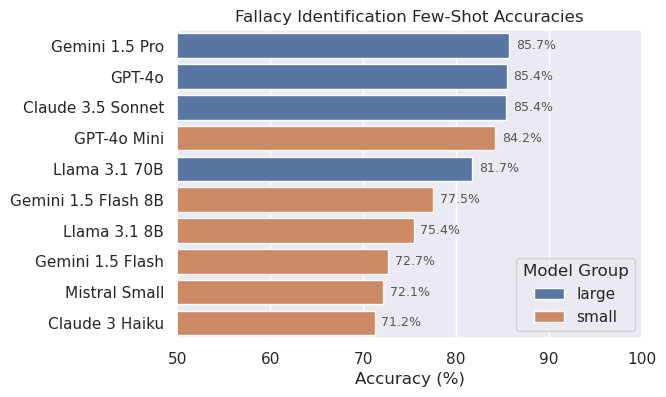

In [160]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e12),
    figsize=(6, 4),
    title='Fallacy Identification Few-Shot Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)


- Mistral Large responded "Yes. No. No. Yes. Yes." hundreds of times, which explains the low accuracy.

### Fallacy Category Accuracies

In [161]:
display_llm_table(df_category_accuracies_e12)

category,formal,informal
llm_label,,
GPT-4o,84.792,86.051
Claude 3.5 Sonnet,85.781,85.015
Gemini 1.5 Pro,84.948,86.42
GPT-4o Mini,81.979,86.348
Claude 3 Haiku,69.583,72.86
Gemini 1.5 Flash,71.458,73.946
Gemini 1.5 Flash 8B,76.302,78.769
Llama 3.1 70B,78.49,84.922
Llama 3.1 8B,68.854,81.967


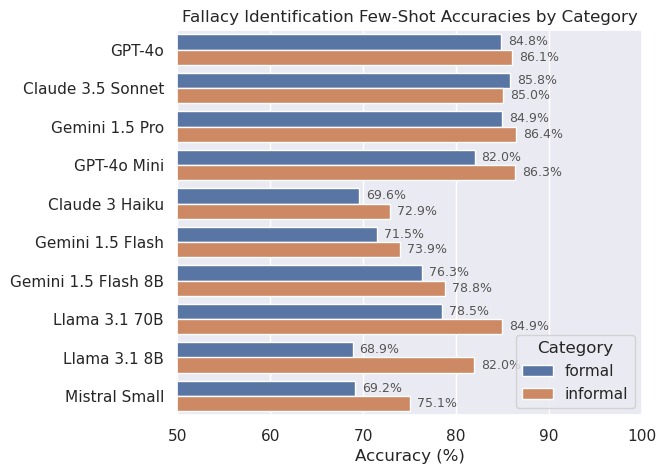

In [162]:
df_category_accuracies_long_e12 = pd.melt(df_category_accuracies_e12, var_name='category', value_name='accuracy', ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e12),
    figsize=(6, 5),
    title='Fallacy Identification Few-Shot Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [163]:
display_llm_table(df_subcategory_accuracies_e12.droplevel(0, axis=1), digits=1)


subcategory,probabilistic,propositional,quantificational,syllogistic,ambiguity,inappropriate presumption,inconsistency,insufficiency,irrelevance
llm_label,,,,,,,,,
GPT-4o,87.5,85.0,76.7,90.0,84.7,86.5,83.3,90.3,85.5
Claude 3.5 Sonnet,85.0,82.5,85.0,90.6,83.0,84.3,88.3,87.0,82.5
Gemini 1.5 Pro,86.2,83.3,83.3,86.9,85.0,85.4,83.3,90.0,88.4
GPT-4o Mini,76.2,88.3,75.8,87.5,84.3,87.3,81.7,90.6,87.8
Claude 3 Haiku,70.0,60.8,70.0,77.5,73.3,74.1,71.7,73.9,71.3
Gemini 1.5 Flash,71.2,62.5,68.3,83.8,74.0,72.5,75.0,72.8,75.4
Gemini 1.5 Flash 8B,75.0,72.5,73.3,84.4,79.7,78.1,78.3,80.8,76.9
Llama 3.1 70B,86.2,65.0,80.8,81.9,83.7,85.5,81.7,88.9,84.9
Llama 3.1 8B,67.5,70.8,65.8,71.2,84.7,80.3,76.7,87.1,81.2


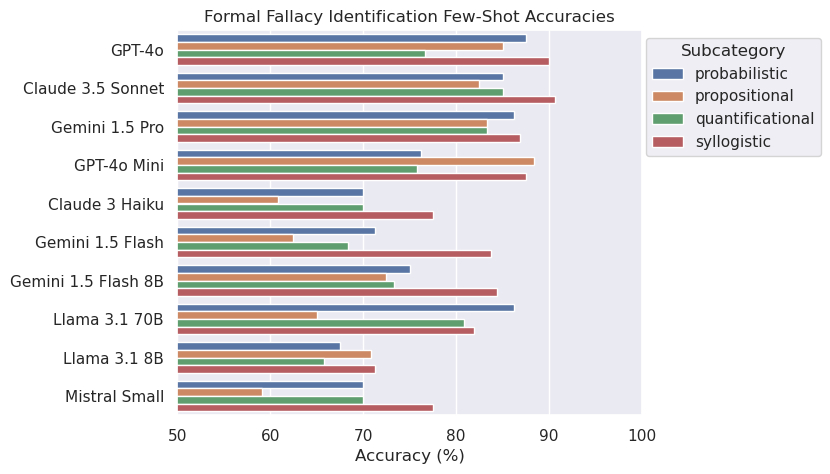

In [164]:
df_subcategory_accuracies_long_e12 = pd.melt(df_subcategory_accuracies_e12, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e12 = df_subcategory_accuracies_long_e12[
    df_subcategory_accuracies_long_e12['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e12),
    figsize=(6, 5),
    title='Formal Fallacy Identification Few-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

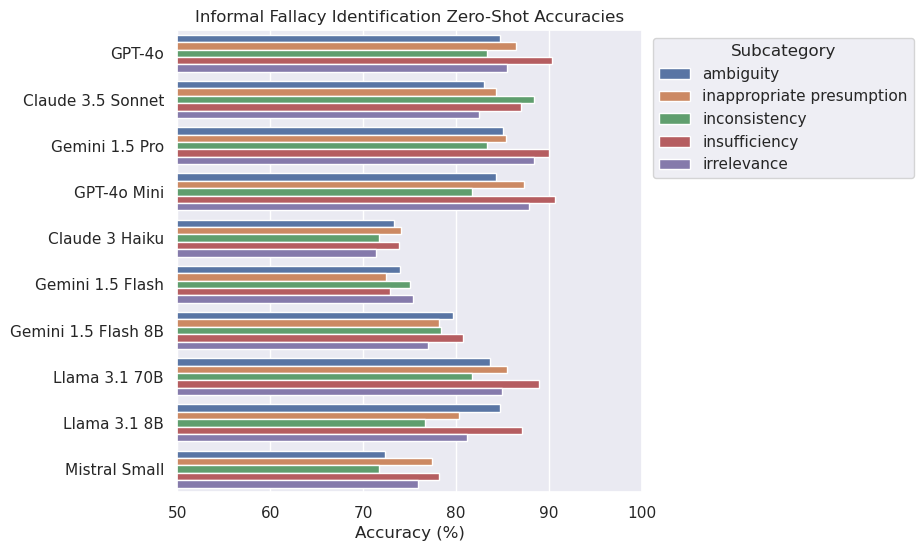

In [165]:
df_informal_accuracies_long_e12 = df_subcategory_accuracies_long_e12[
    df_subcategory_accuracies_long_e12['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e12),
    figsize=(6, 6),
    title='Informal Fallacy Identification Zero-Shot Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

## Experiment 1.3: Fallacy Identification with Chain-of-Thought Prompt

In [166]:
filename_e13 = 'data/fallacies_e13.csv'
df_fallacies_e13 = get_fallacy_df(filename_e13)

[2025-01-30 23:21:38] Loaded existing fallacy dataframe from data/fallacies_e13.csv.


### Scoring and Sanity Check

In [167]:
add_identification_scores(df_fallacies_e13)

# save_fallacy_df(df_fallacies_e13, filename_e13)

df_fallacies_e13.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
0,Since John asked Maria if she used the last of...,tepas,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. Joh...,No. Silence is not necessarily an admission o...,No.,...,1,1,1,1,1,1,1,1,1,1
1,Since Alice asked if Bob knew what an 'ossia' ...,ossia,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. Bob's s...,Let's think through this step by step: 1. Ali...,No. Silence could indicate a lack of knowledg...,No.,...,1,1,1,1,1,1,1,1,1,1
2,Since Alice claims that the Hausdorff contents...,hausdorff contents,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The con...,Let's think through this step-by-step: 1. Ali...,No. Bob's silence doesn't confirm Alice's cla...,No.,...,1,1,1,1,1,1,1,1,1,1
3,"Since Tom, a seasoned tugboater, said that ice...",tugboaters,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not necessarily corr...,Let's think through this step-by-step: 1. The...,"No. While Tom's experience is valuable, the a...",No.,...,1,1,1,1,1,1,1,1,1,1
4,Since John accuses Mary of being terrified of ...,beewolf,Argument from Silence,1,informal,insufficiency,No. The reasoning step is not correct. The fac...,Let's think through this step-by-step: 1. Joh...,No. Silence does not imply guilt or fear. Ma...,No.,...,1,1,1,1,1,1,1,1,1,1


In [168]:
# Check completeness of responses, predictions and scores
df_fallacies_e13.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   step                          4640 non-null   object  
 1   entity                        4640 non-null   object  
 2   fallacy                       4640 non-null   category
 3   label                         4640 non-null   category
 4   category                      4640 non-null   category
 5   subcategory                   4640 non-null   category
 6   gpt_4o_response               4640 non-null   object  
 7   claude_3_5_sonnet_response    4640 non-null   object  
 8   gemini_1_5_pro_response       4638 non-null   object  
 9   gpt_4o_mini_response          4640 non-null   object  
 10  claude_3_haiku_response       4640 non-null   object  
 11  gemini_1_5_flash_response     4639 non-null   object  
 12  gemini_1_5_flash_8b_response  4640 non-null   ob

In [169]:
display_llm_table(get_sanity_check(df_fallacies_e13))

,response_length_mean,missing_responses,invalid_predictions
llm_label,,,
GPT-4o,340.4,0,32
Claude 3.5 Sonnet,1160.1,0,58
Gemini 1.5 Pro,199.4,2,26
GPT-4o Mini,5.9,0,0
Claude 3 Haiku,826.4,0,71
Gemini 1.5 Flash,245.0,1,6
Gemini 1.5 Flash 8B,222.8,0,0
Llama 3.1 70B,904.7,0,149
Llama 3.1 8B,757.9,0,19


- Chain of thought responses are longer and more complex. In a few cases, a clear Yes/No answer cannot be determined.
- GPT-4o Mini's low average response lenght indicates that it ignored the chain-of-thought instructions and just responded with Yes/No.

In [170]:
# Show invalid responses
df_invalid_predictions_e13 = df_fallacies_e13[df_fallacies_e13.isna().any(axis=1)]
df_invalid_predictions_e13.head()

,step,entity,fallacy,label,category,subcategory,gpt_4o_response,claude_3_5_sonnet_response,gemini_1_5_pro_response,gpt_4o_mini_response,...,gemini_1_5_flash_8b_pred,gemini_1_5_flash_8b_score,llama_3_1_70b_pred,llama_3_1_70b_score,llama_3_1_8b_pred,llama_3_1_8b_score,mistral_large_2_pred,mistral_large_2_score,mistral_small_2_pred,mistral_small_2_score
16,Since Samantha claims that wheelbirds exist in...,wheelbirds,Argument from Silence,0,informal,insufficiency,Yes. The reasoning is correct. Samantha's clai...,Let's think through this step by step: 1. Sam...,"Yes. Samantha's claim without evidence, coupl...",Yes.,...,0,1,0,1,1,0,0,1,0,1
36,Since I declare that the city of Bergamo is th...,bergamo,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes.,Let's break this down step by step: 1. The st...,Yes,Yes.,...,0,1,NaN,0,1,0,0,1,0,1
37,Since I claim that benzopyran has magical prop...,benzopyran,Shifting of the Burden of Proof,0,informal,inappropriate presumption,Yes. The reasoning step is correct. Claims abo...,Let's break this down step by step: 1. The st...,Yes,Yes.,...,0,1,NaN,0,1,0,0,1,0,1
57,Since seining is a traditional fishing method ...,seining,Political Correctness Fallacy,0,informal,irrelevance,Yes. The reasoning step acknowledges the cultu...,Let's break down this reasoning step by step: ...,Yes. The reasoning acknowledges the value of ...,Yes.,...,0,1,NaN,0,0,1,0,1,0,1
75,Since ghetto fences are either a symbol of sep...,ghetto fences,Affirming a Disjunct,0,formal,propositional,Yes. The reasoning is correct. The statement a...,Let's break this down step by step: 1. The st...,Yes. The premise states the fences can be *ei...,Yes.,...,0,1,NaN,0,0,1,0,1,1,0


### Overall Accuracies

In [171]:
_, df_subcategory_accuracies_e13, df_category_accuracies_e13, df_overall_accuracies_e13 = get_macro_accuracies(df_fallacies_e13)

In [172]:
df_overall_accuracies_e13 = df_overall_accuracies_e13.sort_values('accuracy', ascending=False)
display_llm_table(df_overall_accuracies_e13)

,accuracy
llm_label,
GPT-4o,86.373
Gemini 1.5 Pro,82.82
GPT-4o Mini,81.568
Claude 3.5 Sonnet,80.842
Llama 3.1 70B,80.501
Claude 3 Haiku,79.897
Gemini 1.5 Flash,79.845
Mistral Large,79.573
Gemini 1.5 Flash 8B,77.709


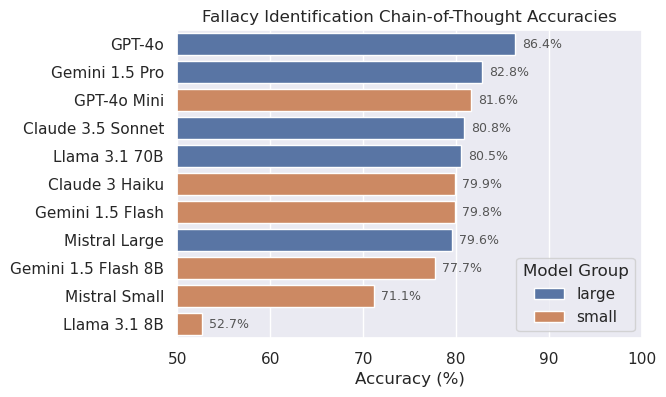

In [173]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e13),
    figsize=(6, 4),
    title='Fallacy Identification Chain-of-Thought Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Category Accuracies

In [174]:
display_llm_table(df_category_accuracies_e13, digits=1)

category,formal,informal
llm_label,,
GPT-4o,83.2,89.6
Claude 3.5 Sonnet,81.3,80.4
Gemini 1.5 Pro,81.0,84.6
GPT-4o Mini,76.2,86.9
Claude 3 Haiku,73.5,86.3
Gemini 1.5 Flash,80.3,79.4
Gemini 1.5 Flash 8B,75.3,80.1
Llama 3.1 70B,78.4,82.6
Llama 3.1 8B,49.9,55.5


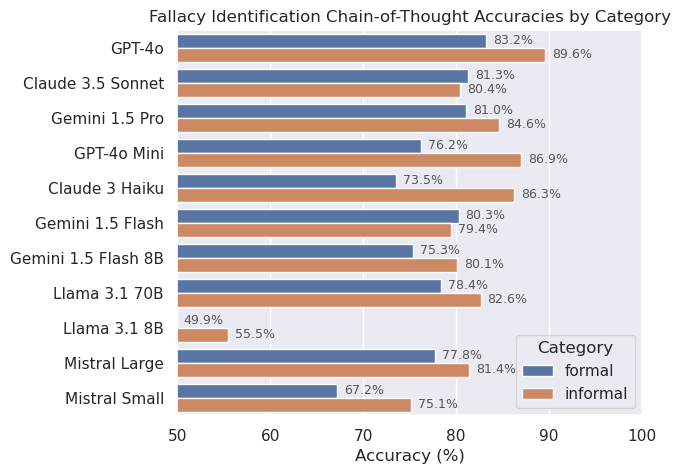

In [175]:
df_category_accuracies_long_e13 = pd.melt(df_category_accuracies_e13, var_name='category', value_name='accuracy',
                                         ignore_index=False)

plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e13),
    figsize=(6, 5),
    title='Fallacy Identification Chain-of-Thought Accuracies by Category',
    hue='category',
    legend_title='Category',
    annotate=True,
    xlim=(50, 100),
)

### Fallacy Subcategory Accuracies

In [176]:
display_llm_table(df_subcategory_accuracies_e13.droplevel(0, axis=1), digits=1)

subcategory,probabilistic,propositional,quantificational,syllogistic,ambiguity,inappropriate presumption,inconsistency,insufficiency,irrelevance
llm_label,,,,,,,,,
GPT-4o,87.5,83.3,82.5,79.4,86.7,88.1,91.7,92.4,89.0
Claude 3.5 Sonnet,85.0,90.8,75.0,74.4,74.3,83.0,81.7,84.2,78.7
Gemini 1.5 Pro,82.5,87.5,79.2,75.0,82.3,86.2,80.0,88.4,86.1
GPT-4o Mini,77.5,74.2,72.5,80.6,83.7,88.0,86.7,90.7,85.7
Claude 3 Haiku,77.5,74.2,72.5,70.0,84.3,87.0,86.7,87.6,85.6
Gemini 1.5 Flash,77.5,81.7,77.5,84.4,80.0,79.6,81.7,80.1,75.8
Gemini 1.5 Flash 8B,76.2,70.8,74.2,80.0,78.0,79.0,83.3,82.6,77.6
Llama 3.1 70B,81.2,86.7,77.5,68.1,80.7,84.4,76.7,87.3,84.0
Llama 3.1 8B,51.2,50.8,48.3,49.4,54.0,56.9,50.0,59.1,57.3


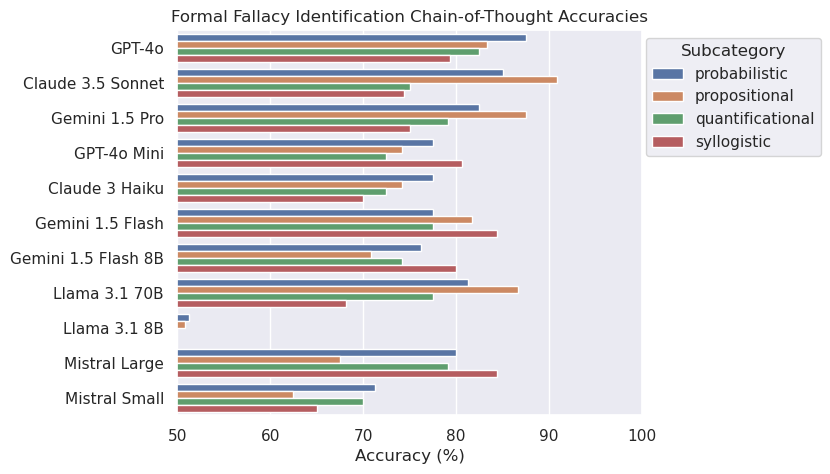

In [177]:
df_subcategory_accuracies_long_e13 = pd.melt(df_subcategory_accuracies_e13, value_name='accuracy', ignore_index=False)
df_formal_accuracies_long_e13 = df_subcategory_accuracies_long_e13[df_subcategory_accuracies_long_e13['category'] == 'formal']

plot_accuracies(
    data=add_llm_info(df_formal_accuracies_long_e13),
    figsize=(6, 5),
    title='Formal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',    
    legend_anchor=(1.4, 1),
    annotate=False,
    xlim=(50, 100),
)

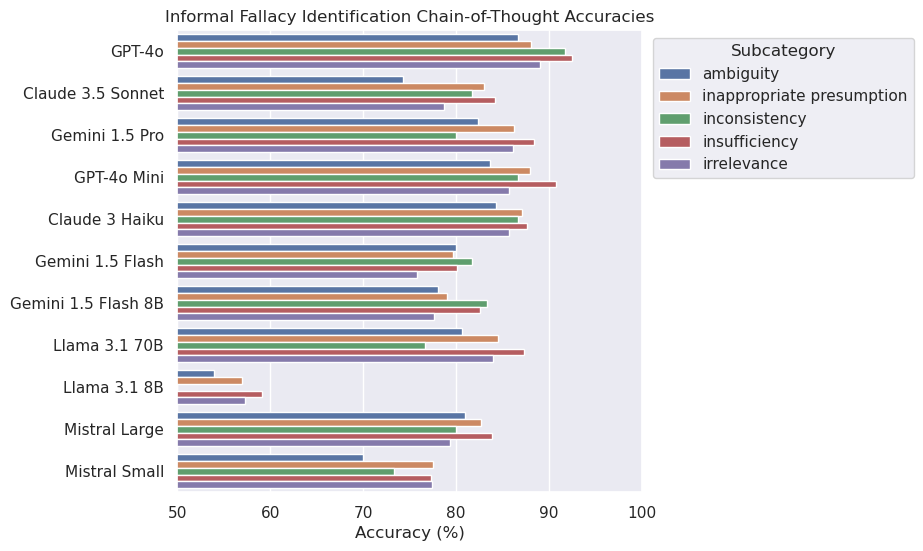

In [178]:
df_informal_accuracies_long_e13 = df_subcategory_accuracies_long_e13[df_subcategory_accuracies_long_e13['category'] == 'informal']

plot_accuracies(
    data=add_llm_info(df_informal_accuracies_long_e13),
    figsize=(6, 6),
    title='Informal Fallacy Identification Chain-of-Thought Accuracies',
    hue='subcategory',
    legend_title='Subcategory',
    legend_loc='upper right',
    legend_anchor=(1.6, 1),
    annotate=False,
    xlim=(50, 100),
)

### Llama 3.1 8B Confusion Matrix

In [179]:
df_confusion_matrices_e13 = get_confusion_matrices(df_fallacies_e13, 'label')

In [180]:
df_llm_confusion_metrics_e13 = get_identification_confusion_metrics(df_confusion_matrices_e13, 'llm')
display_llm_table(df_llm_confusion_metrics_e11)

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar
llm_label,,,,,,,,,,
Claude 3.5 Sonnet,2209,1672,648,111,5.8,0.836,0.773,0.952,0.853,0.000
Claude 3 Haiku,2203,1635,685,117,5.9,0.827,0.763,0.950,0.846,0.000
Claude 3 Opus,2191,1665,655,129,5.1,0.831,0.770,0.944,0.848,0.000
DeepSeek R1 14B,2164,1423,895,154,5.8,0.774,0.707,0.934,0.805,0.000
Gemini 1.5 Flash,2159,1702,618,161,3.8,0.832,0.777,0.931,0.847,0.000
Gemini 1.5 Flash 8B,2133,1766,554,187,3.0,0.840,0.794,0.919,0.852,0.000
Gemini 1.5 Pro,2090,2025,295,230,1.3,0.887,0.876,0.901,0.888,0.005
GPT-4,2017,2148,172,303,0.6,0.898,0.921,0.869,0.895,0.000
GPT-4o,2031,2071,249,289,0.9,0.884,0.891,0.875,0.883,0.093


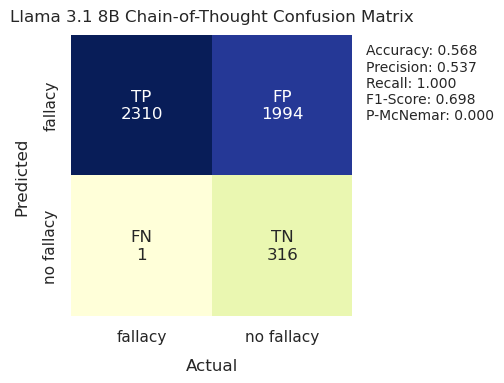

In [181]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e13.loc[LLM.LLAMA_3_1_8B.key],
    title=f'{LLM.LLAMA_3_1_8B.label} Chain-of-Thought Confusion Matrix',
    figsize=(5, 4),
)

- The very low Llama 3.1 8B accuracy is explained by an extremely high false positive rate.

## Prompt Method Comparison

In [182]:
df_zero_shot_accuracies = df_overall_accuracies_e11.copy()
df_zero_shot_accuracies['method'] = 'zero-shot'
df_few_shot_accuracies = df_overall_accuracies_e12.copy()
df_few_shot_accuracies['method'] = 'few-shot'
df_chain_of_thought_accuracies = df_overall_accuracies_e13.copy()
df_chain_of_thought_accuracies['method'] = 'chain-of-thought'

df_method_accuracies = pd.concat([df_zero_shot_accuracies, df_few_shot_accuracies, df_chain_of_thought_accuracies])

# Discard models which have not been prompted with all 3 methods
exclude_llms = [llm.key for llm in [LLM.GPT_4, LLM.O1_MINI, LLM.CLAUDE_3_OPUS]]
df_method_accuracies = df_method_accuracies[~df_method_accuracies.index.isin(exclude_llms)]


In [183]:
# Create LaTeX table
col_labels = {
    'zero-shot': 'Zero-Shot',
    'few-shot': 'Few-Shot',
    'chain-of-thought': 'CoT',
}
df_latex = df_method_accuracies.pivot(columns='method', values='accuracy')[col_labels.keys()]
df_latex = display_llm_table(df_latex, digits=1).sort_values('zero-shot', ascending=False)
df_latex.columns = col_labels.values()
df_latex

,Zero-Shot,Few-Shot,CoT
llm_label,,,
Gemini 1.5 Pro,87.1,85.7,82.8
GPT-4o,86.8,85.4,86.4
Claude 3.5 Sonnet,83.8,85.4,80.8
GPT-4o Mini,83.0,84.2,81.6
Llama 3.1 70B,83.0,81.7,80.5
Gemini 1.5 Flash,82.2,72.7,79.8
Gemini 1.5 Flash 8B,81.3,77.5,77.7
DeepSeek R1 14B,79.4,<NA>,<NA>
Claude 3 Haiku,78.9,71.2,79.9


In [184]:
print(df_latex.to_latex(float_format="%.1f", column_format='l'+'c'*3, na_rep='-',
                                         caption='Fallacy Identification Prompt Method Accuracies'))

\begin{table}
\caption{Fallacy Identification Prompt Method Accuracies}
\begin{tabular}{lccc}
\toprule
 & Zero-Shot & Few-Shot & CoT \\
llm_label &  &  &  \\
\midrule
Gemini 1.5 Pro & 87.1 & 85.7 & 82.8 \\
GPT-4o & 86.8 & 85.4 & 86.4 \\
Claude 3.5 Sonnet & 83.8 & 85.4 & 80.8 \\
GPT-4o Mini & 83.0 & 84.2 & 81.6 \\
Llama 3.1 70B & 83.0 & 81.7 & 80.5 \\
Gemini 1.5 Flash & 82.2 & 72.7 & 79.8 \\
Gemini 1.5 Flash 8B & 81.3 & 77.5 & 77.7 \\
DeepSeek R1 14B & 79.4 & - & - \\
Claude 3 Haiku & 78.9 & 71.2 & 79.9 \\
Mistral Large & 75.8 & - & 79.6 \\
Llama 3.1 8B & 71.0 & 75.4 & 52.7 \\
Mistral Small & 64.9 & 72.1 & 71.1 \\
\bottomrule
\end{tabular}
\end{table}



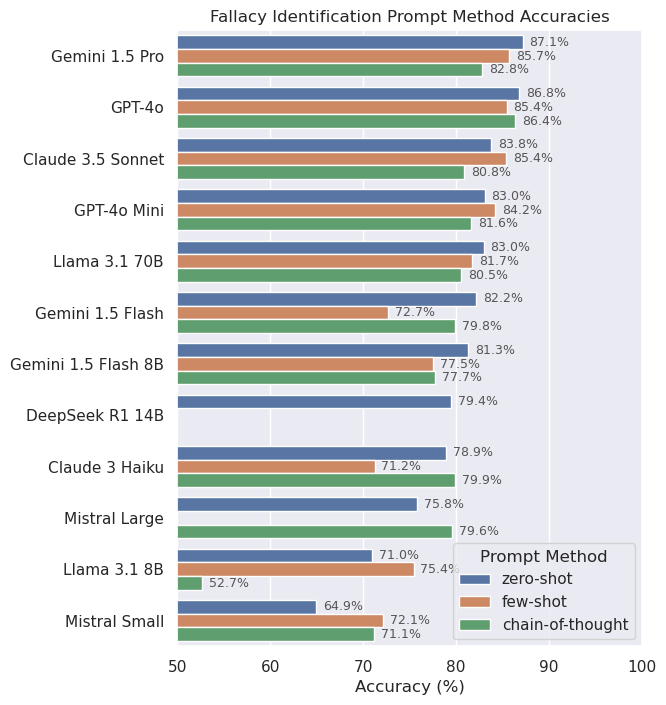

In [185]:
plot_accuracies(
    data=add_llm_info(df_method_accuracies),
    figsize=(6, 8),
    title='Fallacy Identification Prompt Method Accuracies',
    hue='method',
    legend_title='Prompt Method',
    annotate=True,
    xlim=(50, 100),
)

In [186]:
df_plot = add_llm_info(df_method_accuracies, group=True).groupby(['llm_group', 'method'], observed=True).mean().sort_values('method', ascending=False).reset_index()
df_plot

,llm_group,method,accuracy
0,large,zero-shot,83.291747
1,small,zero-shot,76.888429
2,reasoning,zero-shot,79.427428
3,large,few-shot,84.552325
4,small,few-shot,75.526263
5,large,chain-of-thought,82.021431
6,small,chain-of-thought,73.813311


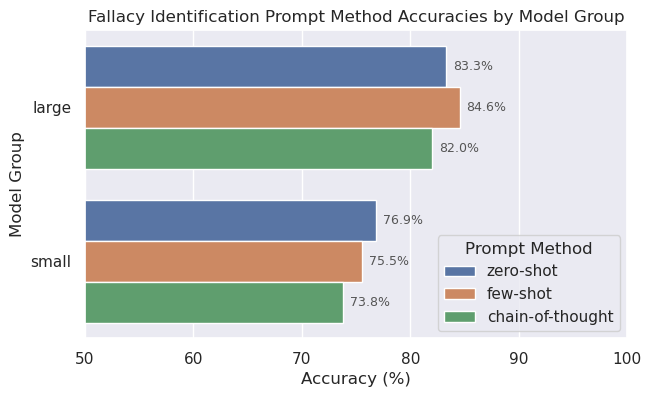

In [187]:
plot_accuracies(
    data=df_plot,
    figsize=(7, 4),
    title='Fallacy Identification Prompt Method Accuracies by Model Group',
    y='llm_group',
    y_label='Model Group',
    hue='method',
    order=[group.value for group in [LLMGroup.LARGE, LLMGroup.SMALL]],
    legend_title='Prompt Method',
    annotate=True,
    xlim=(50, 100),
)

- Few-shot and chain-of-thought prompts don't seem to improve the accuracies, compared to zero-shot prompts.
- Some of the small models seem to get confused by few-shot prompts sometimes, responding with "Yes No No Yes Yes".

## Experiment 1.4: Fallacy Identification with Fine-Tuning

In [188]:
filename_e14 = 'data/fallacies_e14.csv'
df_fallacies_e14 = get_fallacy_df(filename_e14)

[2025-01-30 23:22:06] Loaded existing fallacy dataframe from data/fallacies_e14.csv.


### Scoring and Sanity Check

In [189]:
add_identification_scores(df_fallacies_e14)

# save_fallacy_df(df_fallacies_e14, filename_e14)

# Check completeness of responses
df_fallacies_e14.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320 entries, 0 to 2319
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   step                                 2320 non-null   object  
 1   entity                               2320 non-null   object  
 2   fallacy                              2320 non-null   category
 3   label                                2320 non-null   category
 4   category                             2320 non-null   category
 5   subcategory                          2320 non-null   category
 6   tuning                               2320 non-null   object  
 7   gpt_4o_mini_identification_response  2320 non-null   object  
 8   gpt_4o_mini_identification_pred      2320 non-null   category
 9   gpt_4o_mini_identification_score     2320 non-null   UInt8   
dtypes: UInt8(1), category(5), object(4)
memory usage: 101.4+ KB


In [190]:
get_sanity_check(df_fallacies_e14)

,response_length_mean,missing_responses,invalid_predictions
gpt_4o_mini_identification,2.5,0,0


In [191]:
df_confusion_matrices_e14 = get_confusion_matrices(df_fallacies_e14, 'label')

In [192]:
# Answers from zero-shot identification (experiment 1.1) will be compared with fine-tuned models.
df_fallacies_e14 = df_fallacies_e14.merge(
    df_fallacies_e11.drop(columns=['step', 'category', 'subcategory']),
    on=['entity', 'fallacy', 'label'],
)

### Overall Accuracies

In [193]:
_, df_subcategory_accuracies_e14, df_category_accuracies_e14, df_overall_accuracies_e14 = get_macro_accuracies(df_fallacies_e14)

In [194]:
df_overall_accuracies_e14 = df_overall_accuracies_e14.sort_values('accuracy', ascending=False)
display_llm_table(df_overall_accuracies_e14)

,accuracy
llm_label,
GPT-4o Mini Identification,93.12
GPT-4,87.741
Gemini 1.5 Pro,86.868
o1-mini,85.79
GPT-4o,85.342
Claude 3.5 Sonnet,85.125
Claude 3 Opus,83.033
Gemini 1.5 Flash,82.301
Llama 3.1 70B,82.219


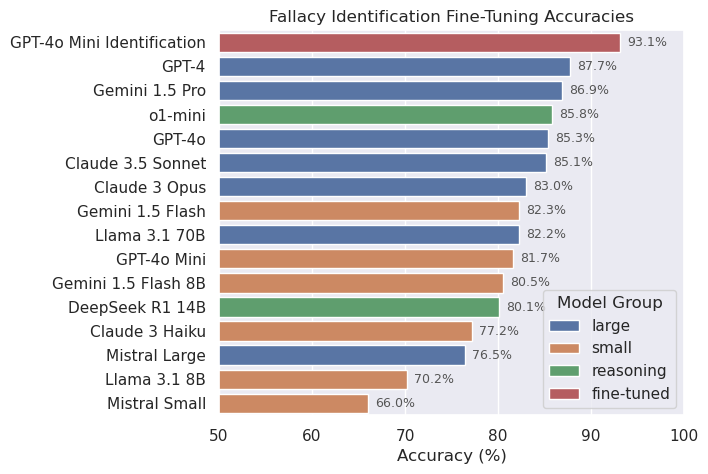

In [195]:
plot_accuracies(
    data=add_llm_info(df_overall_accuracies_e14),
    figsize=(6, 5),
    title='Fallacy Identification Fine-Tuning Accuracies',
    hue='llm_group',
    legend_title='Model Group',
    annotate=True,
    xlim=(50, 100),
)

- Fine-tuning leads to massive increases in identification accuracy.
- Accuracies differ slightly compared to experiment 1.1, they are calculated for the fine-tuning test set.

### Fallacy Category Accuracies

In [196]:
display_llm_table(df_category_accuracies_e14)

category,formal,informal
llm_label,,
GPT-4o Mini Identification,91.042,95.198
GPT-4o,83.125,87.559
GPT-4,87.083,88.399
GPT-4o Mini,76.354,86.953
Claude 3.5 Sonnet,86.042,84.208
Claude 3 Opus,83.021,83.045
Claude 3 Haiku,72.708,81.685
Gemini 1.5 Pro,88.229,85.506
Gemini 1.5 Flash,82.604,81.998


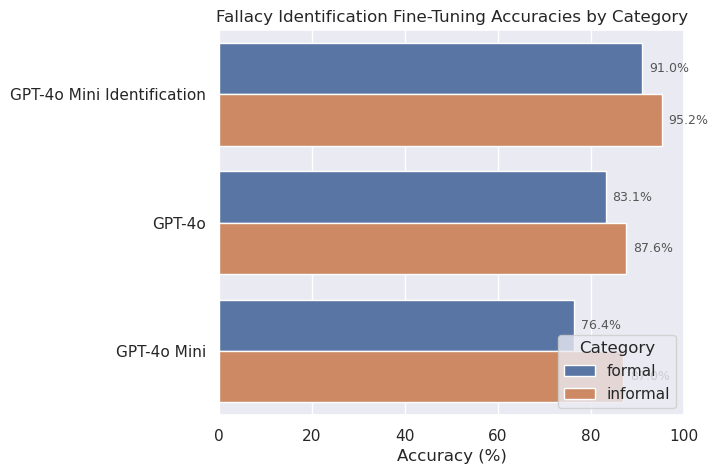

In [197]:
df_category_accuracies_long_e14 = pd.melt(df_category_accuracies_e14, var_name='category', value_name='accuracy',
                                         ignore_index=False)
plot_accuracies(
    data=add_llm_info(df_category_accuracies_long_e14),
    figsize=(6, 5),
    title='Fallacy Identification Fine-Tuning Accuracies by Category',
    hue='category',
    legend_title='Category',
    legend_loc='lower right',
    legend_anchor=(1, 0),
    order=[llm.label for llm in [LLM.GPT_4O_MINI_IDENTIFICATION, LLM.GPT_4O, LLM.GPT_4O_MINI]],
    annotate=True,
)

### Fallacy Confusion Metrics

In [198]:
df_llm_confusion_metrics_e14 = get_identification_confusion_metrics(df_confusion_matrices_e14, 'llm')
display_llm_table(df_llm_confusion_metrics_e14)

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar
llm_label,,,,,,,,,,
GPT-4o Mini Identification,1095,1116,44,65,0.7,0.953,0.961,0.944,0.953,0.055


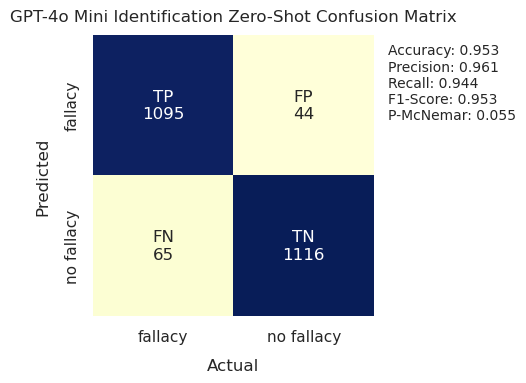

In [199]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e14.loc[LLM.GPT_4O_MINI_IDENTIFICATION.key],
    title=f'{LLM.GPT_4O_MINI_IDENTIFICATION.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

## Experiment 1.5: Fallacy Identification with Rephrased Prompt

A slight variation of the zero-shot identification prompt (experiment 1.1), to see whether false positives can be reduced by wording.

In [200]:
filename_e15 = 'data/fallacies_e15.csv'
df_fallacies_e15 = get_fallacy_df(filename_e15)

[2025-01-30 23:22:13] Loaded existing fallacy dataframe from data/fallacies_e15.csv.


### Scoring and Sanity Check

In [201]:
df_fallacies_e15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   step                        4640 non-null   object  
 1   entity                      4640 non-null   object  
 2   fallacy                     4640 non-null   category
 3   label                       4640 non-null   category
 4   category                    4640 non-null   category
 5   subcategory                 4640 non-null   category
 6   claude_3_5_sonnet_response  4640 non-null   object  
 7   gpt_4o_response             4640 non-null   object  
 8   gemini_1_5_flash_response   4640 non-null   object  
 9   claude_3_5_sonnet_pred      4640 non-null   int64   
 10  claude_3_5_sonnet_score     4640 non-null   int64   
 11  gpt_4o_pred                 4640 non-null   int64   
 12  gpt_4o_score                4640 non-null   int64   
 13  gemini_1_5_flash_p

In [202]:
# Since the prompt asks if there's a fallacy, and not if the reasoning is correct, the predictions are flipped
add_identification_scores(df_fallacies_e15, flip=True)

# save_fallacy_df(df_fallacies_e15, filename_e15)

In [203]:
display_llm_table(get_sanity_check(df_fallacies_e15))

,response_length_mean,missing_responses,invalid_predictions
llm_label,,,
Claude 3.5 Sonnet,2.5,0,0
GPT-4o,3.2,0,0
Gemini 1.5 Flash,2.8,0,0
DeepSeek R1 14B,8.9,4620,4620


### Overall Accuracies

In [204]:
_, df_subcategory_accuracies_e15, df_category_accuracies_e15, df_overall_accuracies_e15 = get_macro_accuracies(df_fallacies_e15)

In [205]:
df_overall_accuracies_e15 = df_overall_accuracies_e15.sort_values('accuracy', ascending=False)
display_llm_table(df_overall_accuracies_e15)

,accuracy
llm_label,
GPT-4o,85.98
Claude 3.5 Sonnet,85.097
Gemini 1.5 Flash,66.546
DeepSeek R1 14B,0.138


- While GPT-4o and Claude 3.5 Sonnet perform similarly for the rephrased zero-shot prompt, Gemini 1.5 Flash accuracy dropped from 82.2% to 66.6%, which is unexpected.

### Accuracy Table

Reproduce accuracy table by Hong et al. (2024)

In [206]:
# Create LaTeX table
df_accuracies_e15 = get_hong_table(df_subcategory_accuracies_e15, df_category_accuracies_e15, df_overall_accuracies_e15)
df_accuracies_e15

,prop.,quant.,syl.,prob.,formal,amb.,incon.,irrel.,insuf.,inappr.,informal,accuracy
Model,,,,,,,,,,,,
GPT-4o,80.0,80.0,85.6,83.8,82.3,88.0,85.0,91.9,92.8,90.5,89.6,86.0
Claude 3.5 Sonnet,85.0,75.0,81.2,80.0,80.3,85.7,90.0,91.0,93.4,89.4,89.9,85.1
Gemini 1.5 Flash,65.8,67.5,65.6,62.5,65.4,66.3,68.3,66.9,70.3,66.9,67.7,66.5
DeepSeek R1 14B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,0.0,0.3,0.1


In [207]:
print(df_accuracies_e15.to_latex(float_format="%.1f", column_format='l'+'c'*12,
                                 caption='Fallacy Identification with Rephrased Prompt Accuracies'))

\begin{table}
\caption{Fallacy Identification with Rephrased Prompt Accuracies}
\begin{tabular}{lcccccccccccc}
\toprule
 & prop. & quant. & syl. & prob. & formal & amb. & incon. & irrel. & insuf. & inappr. & informal & accuracy \\
Model &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
GPT-4o & 80.0 & 80.0 & 85.6 & 83.8 & 82.3 & 88.0 & 85.0 & 91.9 & 92.8 & 90.5 & 89.6 & 86.0 \\
Claude 3.5 Sonnet & 85.0 & 75.0 & 81.2 & 80.0 & 80.3 & 85.7 & 90.0 & 91.0 & 93.4 & 89.4 & 89.9 & 85.1 \\
Gemini 1.5 Flash & 65.8 & 67.5 & 65.6 & 62.5 & 65.4 & 66.3 & 68.3 & 66.9 & 70.3 & 66.9 & 67.7 & 66.5 \\
DeepSeek R1 14B & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.4 & 0.0 & 0.3 & 0.1 \\
\bottomrule
\end{tabular}
\end{table}



### Overall Confusion Metrics



In [208]:
df_confusion_matrices_e15 = get_confusion_matrices(df_fallacies_e15, 'label')

In [209]:
df_overall_confusion_matrix_e15 = df_confusion_matrices_e15.groupby(['label'], observed=True).sum()
df_overall_confusion_matrix_e15

actual,1,0
label,,
1,6567,2024
0,403,4946


In [210]:
# We only care about the metrics for label 1 (fallacy)
df_overall_confusion_metrics_e15 = get_confusion_metrics(df_overall_confusion_matrix_e15)
df_overall_confusion_metrics_e15

,tp,tn,fp,fn,fp/fn,accuracy,precision,recall,f1,p_mcnemar
1,6567,4946,2024,403,5.0,0.825897,0.764405,0.942181,0.844033,9.805383e-259
0,4946,6567,403,2024,0.2,0.825897,0.924659,0.709613,0.802987,9.805383e-259


### LLM Confusion Metrics

In [211]:
df_llm_confusion_metrics_e15 = get_identification_confusion_metrics(df_confusion_matrices_e15, 'llm')
df_latex = get_llm_confusion_metrics_table(df_llm_confusion_metrics_e15)
df_latex

,TP,TN,FP,FN,FP/FN,Accuracy,Precision,Recall,F1,P-McNemar
Model,,,,,,,,,,
GPT-4o,2133,2064,256,187,1.4,0.905,0.893,0.919,0.906,0.001
Claude 3.5 Sonnet,2146,2019,301,174,1.7,0.898,0.877,0.925,0.900,0.000
DeepSeek R1 14B,10,6,4,0,inf,0.800,0.714,1.000,0.833,0.125
Gemini 1.5 Flash,2278,857,1463,42,34.8,0.676,0.609,0.982,0.752,0.000


- For Claude 3.5 Sonnet, the false positives dropped from 648 to 301, but for Gemini 1.5 Flash, they increased from 618 to 1463.
- The rephrased prompt did not have the desired effect of reducing false positives, at least not for all tested LLMs.

In [212]:
df_latex.drop(columns=['P-McNemar'], inplace=True)
print(df_latex.to_latex(float_format="%.3f", column_format='l' + 'c'*9,
                        caption='Fallacy Identification with Rephrased Prompt Confusion Metrics'))

\begin{table}
\caption{Fallacy Identification with Rephrased Prompt Confusion Metrics}
\begin{tabular}{lccccccccc}
\toprule
 & TP & TN & FP & FN & FP/FN & Accuracy & Precision & Recall & F1 \\
Model &  &  &  &  &  &  &  &  &  \\
\midrule
GPT-4o & 2133 & 2064 & 256 & 187 & 1.400 & 0.905 & 0.893 & 0.919 & 0.906 \\
Claude 3.5 Sonnet & 2146 & 2019 & 301 & 174 & 1.700 & 0.898 & 0.877 & 0.925 & 0.900 \\
DeepSeek R1 14B & 10 & 6 & 4 & 0 & inf & 0.800 & 0.714 & 1.000 & 0.833 \\
Gemini 1.5 Flash & 2278 & 857 & 1463 & 42 & 34.800 & 0.676 & 0.609 & 0.982 & 0.752 \\
\bottomrule
\end{tabular}
\end{table}



### Claude Sonnet Confusion Metrics

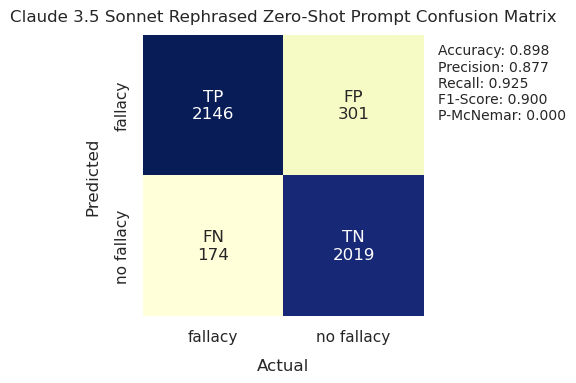

In [213]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e15.loc[LLM.CLAUDE_3_5_SONNET.key],
    title=f'{LLM.CLAUDE_3_5_SONNET.label} Rephrased Zero-Shot Prompt Confusion Matrix',
    figsize=(5, 4),
)

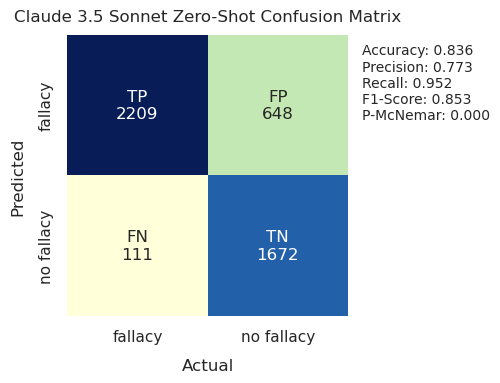

In [214]:
plot_identification_confusion_matrix(
    df_llm_confusion_metrics_e11.loc[LLM.CLAUDE_3_5_SONNET.key],
    title=f'{LLM.CLAUDE_3_5_SONNET.label} Zero-Shot Confusion Matrix',
    figsize=(5, 4),
)

## Experiment 1.6: Fallacy Identification Reliability Test

Are the results from the previous experiment replicable? Since temperature is set to 0, the models should produce the same output for the same input.

In [215]:
filename_e16 = 'data/fallacies_e16.csv'
df_fallacies_e16 = get_fallacy_df(filename_e16)

[2025-01-30 23:22:24] Loaded existing fallacy dataframe from data/fallacies_e16.csv.


### Scoring and Sanity Check

In [216]:
df_fallacies_e16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   step                       4640 non-null   object  
 1   entity                     4640 non-null   object  
 2   fallacy                    4640 non-null   category
 3   label                      4640 non-null   category
 4   category                   4640 non-null   category
 5   subcategory                4640 non-null   category
 6   gpt_4o_mini_response       4640 non-null   object  
 7   claude_3_haiku_response    4640 non-null   object  
 8   gemini_1_5_flash_response  4640 non-null   object  
 9   gpt_4o_mini_pred           4640 non-null   int64   
 10  gpt_4o_mini_score          4640 non-null   int64   
 11  claude_3_haiku_pred        4640 non-null   int64   
 12  claude_3_haiku_score       4640 non-null   int64   
 13  gemini_1_5_flash_pred      4640 n

In [217]:
add_identification_scores(df_fallacies_e16)

# save_fallacy_df(df_fallacies_e16, filename_e16)

In [218]:
# Check completeness of responses, predictions and scores
df_fallacies_e16.replace(['', RESPONSE_ERROR], None).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   step                       4640 non-null   object  
 1   entity                     4640 non-null   object  
 2   fallacy                    4640 non-null   category
 3   label                      4640 non-null   category
 4   category                   4640 non-null   category
 5   subcategory                4640 non-null   category
 6   gpt_4o_mini_response       4640 non-null   object  
 7   claude_3_haiku_response    4640 non-null   object  
 8   gemini_1_5_flash_response  4640 non-null   object  
 9   gpt_4o_mini_pred           4640 non-null   category
 10  gpt_4o_mini_score          4640 non-null   UInt8   
 11  claude_3_haiku_pred        4640 non-null   category
 12  claude_3_haiku_score       4640 non-null   UInt8   
 13  gemini_1_5_flash_pred      4640 n

In [219]:
display_llm_table(get_sanity_check(df_fallacies_e16))

,response_length_mean,missing_responses,invalid_predictions
llm_label,,,
GPT-4o Mini,3.4,0,0
Claude 3 Haiku,3.3,0,0
Gemini 1.5 Flash,2.4,0,0


### Overall Accuracies

In [220]:
_, df_subcategory_accuracies_e16, df_category_accuracies_e16, df_overall_accuracies_e16 = get_macro_accuracies(df_fallacies_e16)

In [221]:
df_overall_accuracies_e16 = df_overall_accuracies_e16.sort_values('accuracy', ascending=False)
display_llm_table(df_overall_accuracies_e16)

,accuracy
llm_label,
GPT-4o Mini,83.131
Gemini 1.5 Flash,81.572
Claude 3 Haiku,78.942


### Accuracy Table

Reproduce accuracy table by Hong et al. (2024)

In [222]:
# Create LaTeX table
df_accuracies_e16 = get_hong_table(df_subcategory_accuracies_e16, df_category_accuracies_e16, df_overall_accuracies_e16)
df_accuracies_e16

,prop.,quant.,syl.,prob.,formal,amb.,incon.,irrel.,insuf.,inappr.,informal,accuracy
Model,,,,,,,,,,,,
GPT-4o Mini,80.8,75.0,83.1,77.5,79.1,84.7,86.7,86.2,90.7,87.5,87.1,83.1
Gemini 1.5 Flash,78.3,80.8,86.2,75.0,80.1,80.7,83.3,80.8,86.6,83.8,83.0,81.6
Claude 3 Haiku,69.2,74.2,80.6,78.8,75.7,81.0,78.3,82.7,85.9,83.1,82.2,78.9


In [223]:
print(df_accuracies_e16.to_latex(float_format="%.1f", column_format='l'+'c'*12,
                                 caption='Fallacy Identification Reliability Test Accuracies'))

\begin{table}
\caption{Fallacy Identification Reliability Test Accuracies}
\begin{tabular}{lcccccccccccc}
\toprule
 & prop. & quant. & syl. & prob. & formal & amb. & incon. & irrel. & insuf. & inappr. & informal & accuracy \\
Model &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
GPT-4o Mini & 80.8 & 75.0 & 83.1 & 77.5 & 79.1 & 84.7 & 86.7 & 86.2 & 90.7 & 87.5 & 87.1 & 83.1 \\
Gemini 1.5 Flash & 78.3 & 80.8 & 86.2 & 75.0 & 80.1 & 80.7 & 83.3 & 80.8 & 86.6 & 83.8 & 83.0 & 81.6 \\
Claude 3 Haiku & 69.2 & 74.2 & 80.6 & 78.8 & 75.7 & 81.0 & 78.3 & 82.7 & 85.9 & 83.1 & 82.2 & 78.9 \\
\bottomrule
\end{tabular}
\end{table}



### Differences between Experiments 1.1 and 1.6

In [224]:
for pred_col in [col for col in df_fallacies_e16.columns if col.endswith('_pred')]:
    llm_key = pred_col.replace('_pred', '')
    n_mismatches = (df_fallacies_e11[pred_col] != df_fallacies_e16[pred_col]).sum()
    print(f'Prediction mismatches for {llm_key}: {n_mismatches} ({n_mismatches / len(df_fallacies_e16):.1%})')

Prediction mismatches for gpt_4o_mini: 58 (1.2%)
Prediction mismatches for claude_3_haiku: 0 (0.0%)
Prediction mismatches for gemini_1_5_flash: 86 (1.9%)


- The predictions are not 100% identical, but the differences are small. Even though temperature is set to 0, not all models are deterministic.
- The accuracies are very similar, since some predictions flip from correct to incorrect and vice versa.